Parameter summary: c1=7.1379, k1=182366.4802, c2=-46.3700, k2=208098.8146, kc~=-55647.6379


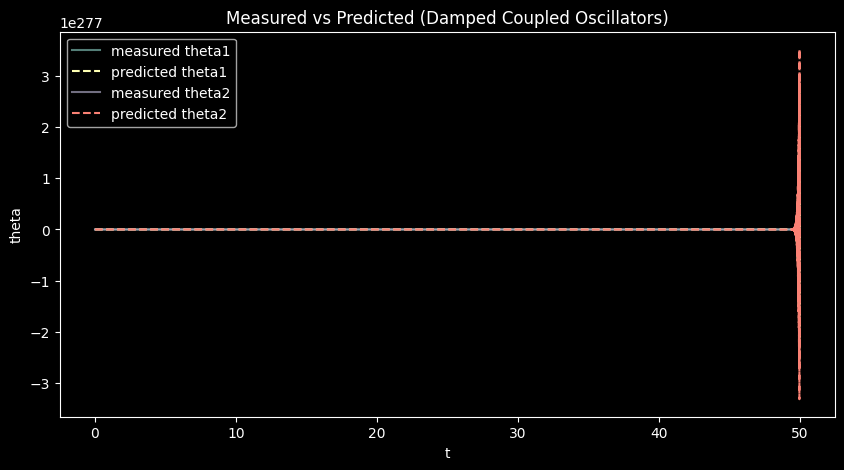

In [59]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('data.csv', delimiter=',', skiprows=1)
t = data[:, 0]
th1 = data[:, 1]
th2 = data[:, 2]

# compute derivatives using gradients (handles non-uniform spacing)
dth1 = np.gradient(th1, t)
ddth1 = np.gradient(dth1, t)
dth2 = np.gradient(th2, t)
ddth2 = np.gradient(dth2, t)

# build linear systems: ddth1 = -c1*dth1 - k1*th1 - kc*(th1 - th2)
A1 = np.column_stack([-dth1, -th1, -(th1 - th2)])
p1, *_ = np.linalg.lstsq(A1, ddth1, rcond=None)
c1, k1, kc1 = p1

# second equation: ddth2 = -c2*dth2 - k2*th2 - kc*(th2 - th1)
A2 = np.column_stack([-dth2, -th2, -(th2 - th1)])
p2, *_ = np.linalg.lstsq(A2, ddth2, rcond=None)
c2, k2, kc2 = p2

# combine kc estimates
kc = 0.5 * (kc1 + kc2)

print(f"Parameter summary: c1={c1:.4f}, k1={k1:.4f}, c2={c2:.4f}, k2={k2:.4f}, kc~={kc:.4f}")

# simulate the linear coupled system using solve_ivp
def coupled_rhs(ti, y):
    th1_, v1, th2_, v2 = y
    a1 = -c1 * v1 - k1 * th1_ - kc * (th1_ - th2_)
    a2 = -c2 * v2 - k2 * th2_ - kc * (th2_ - th1_)
    return [v1, a1, v2, a2]

y0 = [th1[0], dth1[0], th2[0], dth2[0]]
sol = solve_ivp(coupled_rhs, (t[0], t[-1]), y0, t_eval=t, rtol=1e-6)

# plot measured vs predicted
plt.figure(figsize=(10, 5))
plt.plot(t, th1, label='measured theta1', alpha=0.6)
plt.plot(t, sol.y[0], '--', label='predicted theta1')
plt.plot(t, th2, label='measured theta2', alpha=0.6)
plt.plot(t, sol.y[2], '--', label='predicted theta2')
plt.legend()
plt.xlabel('t')
plt.ylabel('theta')
plt.title('Measured vs Predicted (Damped Coupled Oscillators)')
plt.show()

In [60]:
import math

def analyze_sensors(filename):
    """Read CSV without pandas, filter out bad rows, compute mean and std per sensor.
    Expects a header with at least: timestamp,sensor_id,voltage,status"""
    sensors = {}
    with open(filename, 'r') as f:
        header = f.readline().strip().split(',')
        # map columns
        col_idx = {name: i for i, name in enumerate(header)}
        for line in f:
            parts = line.strip().split(',')
            if len(parts) != len(header):
                continue
            try:
                status = parts[col_idx.get('status')].strip()
                voltage = float(parts[col_idx.get('voltage')])
                sensor = parts[col_idx.get('sensor_id')].strip()
            except Exception:
                continue
            # filter out bad readings
            if status == 'ERR' or voltage > 10.0:
                continue
            sensors.setdefault(sensor, []).append(voltage)

    for sensor, vals in sorted(sensors.items()):
        n = len(vals)
        if n == 0:
            print(f"{sensor}: no valid readings")
            continue
        mean = sum(vals) / n
        var = sum((x - mean) ** 2 for x in vals) / (n - 1) if n > 1 else 0.0
        std = math.sqrt(var)
        print(f"{sensor}: count={n}, mean={mean:.4f}, std={std:.4f}")

analyze_sensors("sensor_log.csv")

S1: count=111, mean=4.0265, std=0.5452
S2: count=102, mean=4.0552, std=0.5855
S3: count=124, mean=3.9269, std=0.5791
S4: count=128, mean=3.9734, std=0.5861


## SciPy

### Task 1

Find the positive root of the transcendental equation: $x^2 - 5\sin(x) - 2 = 0$

import math

def f(x):
    return x**2 - 5 * math.sin(x) - 2

def find_positive_root(a=0.0, b=3.0, tol=1e-10, maxiter=200):
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        # try expanding interval until sign change or give up
        for _ in range(50):
            b *= 2
            fb = f(b)
            if fa * fb <= 0:
                break
        else:
            raise ValueError('Cannot find sign change for root search')
    for _ in range(maxiter):
        m = 0.5 * (a + b)
source
print('Damped coupled-oscillator analysis is implemented in a previous cell.')
# The N-Body Problem
In classical mechanics, the Two-Body problem (e.g., Earth-Moon) has an analytical solution. However, adding a third body makes the system unsolvable by pen and paper. To predict the motion of star clusters or galaxies, we solve the **N-Body problem** numerically.

**Objective:** Your task is to implement a vectorized N-Body simulation using Python and NumPy.

**Important: You are not allowed to use any loops for physics calculations.**

### The Physics & The Numerical Problem

The acceleration $\vec{a}_i$ acting on particle $i$ is the sum of gravitational forces from all other particles $j$.
$$\vec{a}_i = \sum_{j \neq i} G \cdot m_j \cdot \frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

**The Numerical Issue:**
As particles get close, $|\vec{r}_j - \vec{r}_i| \to 0$, causing the force to shoot to infinity (Singularity). In a discrete time-step simulation, this flings particles out of the galaxy at unphysical speeds.

**Q. Explain, how would you overcome this issue (you may introduce additional parameters if needed)?**

**Q. Does the value of your param ```affect``` your results? If they do then explain how.**

### Setup and Initialization

Run this cell to import libraries and set up the simulation environment. **Do not modify this cell.**

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Simulation Parameters

G = 1.0           # Gravitational Constant
PARAM = 0.1       # Your parameter (if needed)
DT = 0.01         # Time step
STEPS = 200       # Number of steps
N_PARTICLES = 100 # Number of particles

def generate_initial_state(N, seed=42):
    """
    Generates N random particles.
    Returns:
        positions: (N, 2) array
        velocities: (N, 2) array
        masses: (N,) array
    """
    np.random.seed(seed)
    positions = np.random.randn(N, 2)
    velocities = np.random.randn(N, 2) * 0.5
    masses = np.random.rand(N) + 0.5 # Masses between 0.5 and 1.5
    return positions, velocities, masses

In [64]:
# Calculates the net acceleration on every particle due to every other particle.
# Returns accelerations as a (N, 2) numpy array representing a_x, a_y

def calculate_accelerations(positions, masses, G=1.0, param=0.1):
    """Vectorized acceleration calculation for N-body problem.
    positions: (N,2), masses: (N,), param: softening length"""
    N = positions.shape[0]
    # displacement r_j - r_i => shape (N, N, 2)
    disp = positions[None, :, :] - positions[:, None, :]
    # distance squared with softening to avoid singularity
    dist2 = np.sum(disp ** 2, axis=2) + (param ** 2)
    # inv_dist3 = 1 / r^3
    inv_dist3 = dist2 ** -1.5
    # zero self-interaction
    np.fill_diagonal(inv_dist3, 0.0)
    # prefactor includes masses of source particles (j)
    prefactor = G * masses[None, :, None] * inv_dist3[:, :, None]
    # acceleration on i is sum_j prefactor_ij * (r_j - r_i)
    accelerations = np.sum(prefactor * disp, axis=1)
    return accelerations

In [65]:
# TODO 2: Updates the simulation by one timestep.

def symplectic_euler_step(positions, velocities, accelerations, dt):
    # Update velocities (v_{n+1} = v_n + a_n * dt)
    velocities = velocities + accelerations * dt
    # Update positions using new velocities (symplectic Euler)
    positions = positions + velocities * dt
    return positions, velocities

## Visualization

If your code is correct, this block will run the simulation and produce a plot.

**Note:** This block checks if your functions are implemented. If they return `None` or zeros, the plot will look static or empty.

Simulation of 100 particles for 200 steps took: 0.0890s


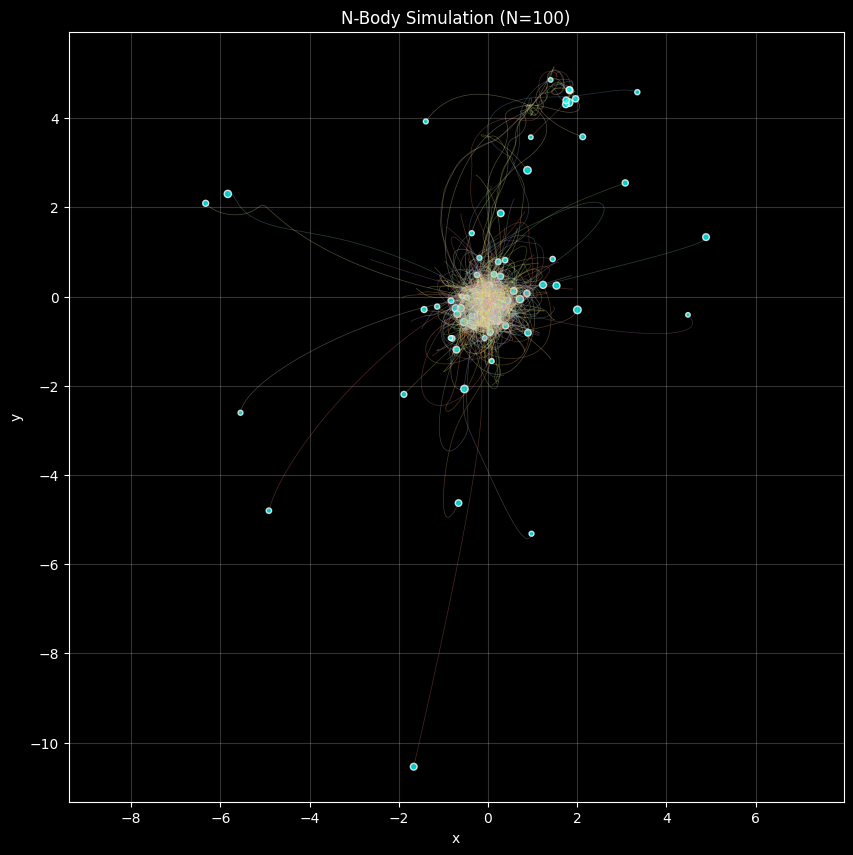

In [66]:
def run_simulation(N=100, steps=200, dt=0.01):
    positions, velocities, masses = generate_initial_state(N)
    
    trajectory_history = []
    trajectory_history.append(positions.copy())
    
    start_time = time.time()
    
    for _ in range(steps):
        # Calculate forces
        acc = calculate_accelerations(positions, masses, G, PARAM)
        
        # Integrate
        positions, velocities = symplectic_euler_step(positions, velocities, acc, dt)
        
        # Store history
        trajectory_history.append(positions.copy())
        
    end_time = time.time()
    print(f"Simulation of {N} particles for {steps} steps took: {end_time - start_time:.4f}s")
    
    return np.array(trajectory_history), masses

# Main Simualtion
history, masses = run_simulation(N=N_PARTICLES, steps=STEPS, dt=DT)

plt.figure(figsize=(10, 10))
plt.style.use('dark_background')

for i in range(N_PARTICLES):
    plt.plot(history[:, i, 0], history[:, i, 1], alpha=0.3, lw=0.5)

# Plot final positions
plt.scatter(history[-1, :, 0], history[-1, :, 1], s=masses*20, c='cyan', alpha=0.8, edgecolors='white')

plt.title(f"N-Body Simulation (N={N_PARTICLES})")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, alpha=0.2)
plt.axis('equal')
plt.show()

## Conservation of Energy

A good physics simulation must conserve energy. 
* **Kinetic Energy (T):** $T = \frac{1}{2} \sum m_i v_i^2$
* **Potential Energy (U):** $U = -\frac{1}{2} \sum_i \sum_{j \neq i} \frac{G m_i m_j}{r_{ij}}$

**Note that the energy functions can also change depending on how you chose the parameter, so if you make any such modification, explain that clearly.**

**Task:** Implement the energy calculation.

In [67]:
# TODO 3: Calculate the Total Energy (Kinetic + Potential).

def calculate_total_energy(positions, velocities, masses, G=1.0, param=0.1):
    # Kinetic Energy: 1/2 sum m v^2
    T = 0.5 * np.sum(masses * np.sum(velocities ** 2, axis=1))
    # Potential Energy: -sum_{i<j} G m_i m_j / r_ij
    N = positions.shape[0]
    disp = positions[None, :, :] - positions[:, None, :]
    dist = np.sqrt(np.sum(disp ** 2, axis=2))
    # avoid divide-by-zero on diagonal by setting large value
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_dist = np.zeros_like(dist)
        mask = dist > 0
        inv_dist[mask] = 1.0 / dist[mask]
    # compute upper triangle to avoid double counting
    U = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            U -= G * masses[i] * masses[j] * inv_dist[i, j]
    return T + U

# Test for a simple 2-body static case
pos_test = np.array([[1.0, 0.0], [-1.0, 0.0]])
vel_test = np.array([[0.0, 0.0], [0.0, 0.0]])
mass_test = np.array([1.0, 1.0])

E_check = calculate_total_energy(pos_test, vel_test, mass_test, G=1.0, param=0.0)
print(f"Test Case Energy: {E_check:.4f} (Expected: -0.500)")

Test Case Energy: -0.5000 (Expected: -0.500)


## Advanced Integration with SciPy

In computational physics, we often use established libraries to verify our manual implementations. SciPy's `solve_ivp` is a powerful integrator with adaptive time-stepping.

**The Challenge:** `solve_ivp` requires the system state to be a **1D array**. You currently have 2D arrays for positions and velocities.

**TODO:**
1.  Flatten your initial `positions` and `velocities` into a single 1D array `y0`.
2.  Implement the derivative function `nbody_ode(t, y, masses, ...)` which:
    * Unpacks the 1D `y` back into `positions` and `velocities`.
    * Calculates `accelerations` using your function from Task 1.
    * Returns the derivatives (velocities and accelerations) as a flattened 1D array.
3.  Run the solver.

## 8. Task 4: Advanced Integration with SciPy

In computational physics, we often use established libraries to verify our manual implementations. SciPy's `solve_ivp` is the industry standard for solving ODEs. 

But `solve_ivp` requires the system state to be a **single 1D array**, but your physics simulation uses separate 2D arrays for position and velocity.

**Task:**
2.  Run the simulation using `solve_ivp`.

In [68]:
from scipy.integrate import solve_ivp

# TODO 4: Implement a function nbody_ode that bridges the gap between scipy 1D requirement and your 2D logic.

def nbody_ode(t, y, masses, G):
    """Bridge function for scipy.solve_ivp: unpack state, compute accelerations, return dydt"""
    N = masses.shape[0]
    # y contains positions then velocities: both flattened (N*2 each)
    pos = y[:2 * N].reshape((N, 2))
    vel = y[2 * N:].reshape((N, 2))
    # compute accelerations using our vectorized routine (use default param for softening)
    acc = calculate_accelerations(pos, masses, G, param=PARAM)
    # pack derivatives: dpos/dt = vel, dvel/dt = acc
    dydt = np.concatenate([vel.ravel(), acc.ravel()])
    return dydt

In [69]:
# Run the simulation using solve_ivp.

N_SCIPY = 10
pos_s, vel_s, mass_s = generate_initial_state(N_SCIPY)
t_span = (0, 2.0)
print(f"Running SciPy Integrator for N={N_SCIPY}...")

# Prepare the initial 1D state vector 'y0' from pos_s and vel_s
y0 = np.concatenate([pos_s.ravel(), vel_s.ravel()])

# Call solve_ivp with our nbody_ode bridge function
try:
    sol = solve_ivp(lambda t, y: nbody_ode(t, y, mass_s, G), t_span, y0, rtol=1e-6, atol=1e-9)
except Exception as e:
    print('solve_ivp failed:', e)
    sol = None

if sol is not None and sol.y.size > 0:
    print(f"SciPy solved in {len(sol.t)} steps.")
    print(f"Final shape of solution: {sol.y.shape}")

Running SciPy Integrator for N=10...
SciPy solved in 246 steps.
Final shape of solution: (40, 246)


# Damped coupled oscillators

The bobs of two pendulums are connected by a spring, forming a coupled oscillator system. Real systems always have some damping, in which mechanical energy is slowly converted to heat. For this problem we model the damping as a force proportional to velocity. Assume that the spring is ideal and that the system is placed on the surface of an unknown extremely large planet. Let $\theta_1$ and $\theta_2$ denote the angles that pendulum strings make with the vertical and $t$ denote time. The equations governing the motion of the system can be written as

$$ \frac{d^2 \theta_1}{d t^2} = -c_1 \frac{d \theta_1}{d t} - k_1 \theta_1 -k_c (\theta_1 - \theta_2)$$
$$ \frac{d^2 \theta_2}{d t^2} = -c_2 \frac{d \theta_2}{d t} - k_2 \theta_2 -k_c (\theta_2 - \theta_1)$$

The file `data.csv` provides you measurements for $\theta_1$ and $\theta_2$ with time. Your task is to find $c_1, c_2, k_1, k_2, k_c$ using python (numpy and/or pandas). Note that the data might have noise and also be partially corruped due to limitations of measuring instruments.  Plot the values of $\theta_1$ and $\theta_2$ predicted using the constants calculated above against the measured values. Assume arbitrary (but consistent) unit system.

In [70]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('data.csv', delimiter=',', skiprows=1)
t = data[:, 0]
th1 = data[:, 1]
th2 = data[:, 2]

# compute derivatives using gradients (handles non-uniform spacing)
dth1 = np.gradient(th1, t)
ddth1 = np.gradient(dth1, t)
dth2 = np.gradient(th2, t)
ddth2 = np.gradient(dth2, t)

# build linear systems: ddth1 = -c1*dth1 - k1*th1 - kc*(th1 - th2)
A1 = np.column_stack([-dth1, -th1, -(th1 - th2)])
p1, *_ = np.linalg.lstsq(A1, ddth1, rcond=None)
c1, k1, kc1 = p1

# second equation: ddth2 = -c2*dth2 - k2*th2 - kc*(th2 - th1)
A2 = np.column_stack([-dth2, -th2, -(th2 - th1)])
p2, *_ = np.linalg.lstsq(A2, ddth2, rcond=None)
c2, k2, kc2 = p2

# combine kc estimates
kc = 0.5 * (kc1 + kc2)

print(f"Parameter summary: c1={c1:.4f}, k1={k1:.4f}, c2={c2:.4f}, k2={k2:.4f}, kc~={kc:.4f}")# print a small summaryplt.show()plt.title('Measured vs Predicted (Damped Coupled Oscillators)')plt.ylabel('theta')plt.xlabel('t')plt.legend()plt.plot(t, sol.y[2], '--', label='predicted theta2')plt.plot(t, th2, label='measured theta2', alpha=0.6)plt.plot(t, sol.y[0], '--', label='predicted theta1')plt.plot(t, th1, label='measured theta1', alpha=0.6)plt.figure(figsize=(10, 5))# plot measured vs predictedsol = solve_ivp(coupled_rhs, (t[0], t[-1]), y0, t_eval=t, rtol=1e-6)y0 = [th1[0], dth1[0], th2[0], dth2[0]]    return [v1, a1, v2, a2]    a2 = -c2 * v2 - k2 * th2_ - kc * (th2_ - th1_)    a1 = -c1 * v1 - k1 * th1_ - kc * (th1_ - th2_)    th1_, v1, th2_, v2 = ydef coupled_rhs(ti, y):# simulate the linear coupled system using solve_ivp c1={c1:.4f}, k1={k1:.4f},\n c2={c2:.4f}, k2={k2:.4f},\n kc~={kc:.4f}")

Parameter summary: c1=7.1379, k1=182366.4802, c2=-46.3700, k2=208098.8146, kc~=-55647.6379
